<a href="https://colab.research.google.com/github/avionerman/machine_learning_2025/blob/main/Exercise_9_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1a: Installations

In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install renderlab
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398778 sha256=58b2d8d92981c3b3ada13e64b5e4fabf66ecc9cde0f4003b513331c3431dce80
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.3 MB/s eta 0:00:00


# 1b: Import libraries

In [2]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import renderlab as rl

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294

# 2: Exlanation of Gymnasium Env (step, reset, render)

**reset()**

Η συναρτηση reset επαναφερει το περιβαλλον στην αρχικη του κατασταση. Οταν την καλεις, το διαστημοπλοιο τοποθετειται ξανα στην κορυφη της οθονης με τυχαια θεση και μηδενικη ταχυτητα, ετοιμο για νεο επεισοδιο. Επιστρεφει την αρχικη παρατηρηση (observation) και ενα info dictionary. Την καλουμε στην αρχη του παιχνιδιου και καθε φορα που τελειωνει ενα επεισοδιο με σκοπο να προσπαθησουμε ξανα, ή να τρεξει το επομενο επεισοδιο.

<br>

**step(action)**

Η συναρτηση step ειναι ο βασικος τροπος αλληλεπιδρασης με το περιβαλλον. Δεχεται μια ενεργεια (0=τιποτα, 1=αριστερος κινητηρας, 2=κυριος κινητηρας, 3=δεξιος κινητηρας) και προσομοιωνει ενα φυσικο βημα. Επιστρεφει πεντε τιμες: τη νεα παρατηρηση, το reward, αν τερματισε το επεισοδιο (terminated), αν διακοπηκε (truncated), και ενα info dictionary. Καλειται επαναληπτικα σε loop για να παιξει ο πρακτορας το παιχνιδι.

<br>

**render()**

Η συναρτηση render δημιουργει οπτικη αναπαρασταση της τρεχουσας καταστασης του περιβαλλοντος. Αναλογα με το render mode (πχ "human" για παραθυρο η "rgb_array" για πινακα pixels), εμφανιζει το παιχνιδι σε πραγματικο χρονο η επιστρεφει την εικονα ως numpy array. Κατα την εκπαιδευση συνηθως δεν την χρησιμοποιουμε γιατι επιβραδυνει τη διαδικασια, αλλα ειναι χρησιμη για debugging και εγγραφη video.


# 3: Explanation of LunarLander-v3 (observation space, action space, reward function)

**Observation Space**

Το observation space του LunarLander-v3 ειναι ενας χωρος (συνεχης) 8 διαστασεων (Box(8)). Καθε παρατηρηση περιεχει τις εξης πληροφοριες για το διαστημοπλοιο: (1) τη θεση x και y, (2) την οριζοντια και καθετη ταχυτητα, (3) τη γωνια κλισης και την γωνιακη ταχυτητα, (4) και τελος δυο boolean τιμες που δειχνουν αν το αριστερο και δεξι ποδι αγγιζουν το εδαφος. Αυτες οι 8 τιμες (χωρισμενες σε 4 sections) δινουν στον πρακτορα ολη την απαραιτητη πληροφορια για να αποφασισει την επομενη ενεργεια του.

<br>

**Action Space**

Το action space ειναι διακριτο με 4 πιθανες ενεργειες (Discrete(4)). Η ενεργεια 0 σημαινει να μην κανει τιποτα, η 1 ενεργοποιει τον αριστερο κινητηρα προσανατολισμου, η 2 ενεργοποιει τον κυριο κινητηρα (προς τα κατω για επιβραδυνση), και η 3 ενεργοποιει τον δεξιο κινητηρα προσανατολισμου. Σε καθε βημα ο πρακτορας επιλεγει ακριβως μια απο αυτες τις ενεργειες. Στο action space υπαγεται και το action(x) οπου x ο αριθμος που οριζει μια ενεργεια (το προσεθεσα στην περιγραφη στο task 2).

<br>

**Reward Function**

Η συναρτηση ανταμοιβης ειναι σχεδιασμενη για να ενθαρρυνει ομαλη προσγειωση στην πλατφορμα. Ο πρακτορας κερδιζει απο 100 εως 140 ποντους για επιτυχη προσγειωση στην πλατφορμα, και επιπλεον 10 ποντους για καθε ποδι που ακουμπαει το εδαφος. Ομως χανει ποντους για χρηση καυσιμου (περιπου 0.3 ανα frame για τον κυριο κινητηρα και 0.03 για τους πλαινους) και παιρνει -100 ποντους αν συντριβει. Το περιβαλλον θεωρειται λυμενο οταν ο πρακτορας πετυχει μεσο σκορ 200 ποντων η παραπανω.

# 4: Random Agent

In [8]:
from IPython.display import HTML
from base64 import b64encode
import imageio

# part of task 4: recording and visualizing a random agent
env = gym.make("LunarLander-v3", render_mode="rgb_array")
frames = []

obs, _ = env.reset(seed=42)
done = False
while not done:
    frames.append(env.render())
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

# displaying video
imageio.mimsave("random_agent.mp4", frames, fps=30)
video = open("random_agent.mp4", "rb").read()
video_encoded = b64encode(video).decode("ascii")
display(HTML(f'<video controls><source src="data:video/mp4;base64,{video_encoded}" type="video/mp4"></video>'))

# part of task 5: running a random agent for 5 episodes
env = gym.make("LunarLander-v3")
random_rewards = []
for ep in range(5):
    obs, _ = env.reset(seed=ep)
    total = 0
    done = False
    while not done:
        obs, r, terminated, truncated, _ = env.step(env.action_space.sample())
        total += r
        done = terminated or truncated
    random_rewards.append(total)
    print(f"episode {ep+1}: {total:.2f}")
env.close()
print(f"\nRandom Agent Mean Score: {np.mean(random_rewards):.2f}")

episode 1: -60.85
episode 2: -125.30
episode 3: -207.14
episode 4: -312.27
episode 5: -208.50

Random Agent Mean Score: -182.81


# 5, 6 & 7: Training of DQN/PPO, Evaluation including Charts

DQN (time): 559.3s, Mean reward: 97.36
PPO (time): 759.9s, Mean reward: 254.04


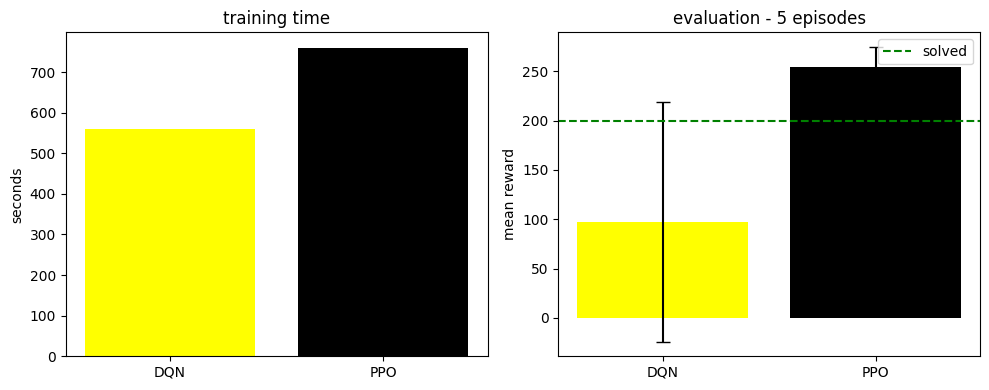

In [13]:
TIMESTEPS = 500000

# DQN training
env = gym.make("LunarLander-v3")
dqn_start = time.time()
dqn_model = DQN("MlpPolicy", env, verbose=0)
dqn_model.learn(total_timesteps=TIMESTEPS)
dqn_time = time.time() - dqn_start
env.close()

# PPO training
env = gym.make("LunarLander-v3")
ppo_start = time.time()
ppo_model = PPO("MlpPolicy", env, verbose=0)
ppo_model.learn(total_timesteps=TIMESTEPS)
ppo_time = time.time() - ppo_start
env.close()

# methods evaluation for 5 episodes each
def evaluate(model, n=5):
    env = gym.make("LunarLander-v3")
    rewards = []
    for i in range(n):
        obs, _ = env.reset(seed=i)
        total = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, _ = env.step(action)
            total += r
            done = terminated or truncated
        rewards.append(total)
    env.close()
    return rewards

dqn_rewards = evaluate(dqn_model)
ppo_rewards = evaluate(ppo_model)

print(f"DQN (time): {dqn_time:.1f}s, Mean reward: {np.mean(dqn_rewards):.2f}")
print(f"PPO (time): {ppo_time:.1f}s, Mean reward: {np.mean(ppo_rewards):.2f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(['DQN', 'PPO'], [dqn_time, ppo_time], color=['yellow', 'black'])
axes[0].set_ylabel('seconds')
axes[0].set_title('training time')

axes[1].bar(['DQN', 'PPO'], [np.mean(dqn_rewards), np.mean(ppo_rewards)],
            yerr=[np.std(dqn_rewards), np.std(ppo_rewards)], color=['yellow', 'black'], capsize=5)
axes[1].axhline(200, color='green', linestyle='--', label='solved')
axes[1].set_ylabel('mean reward')
axes[1].set_title('evaluation - 5 episodes')
axes[1].legend()
plt.tight_layout()
plt.show()

# 8a: Tunning Hyperparameters (SB3 RL Zoo)

DQN Tuned (time): 565.0s, Mean Reward: 223.63
PPO Tuned (time): 584.8s, Mean Reward: 237.14


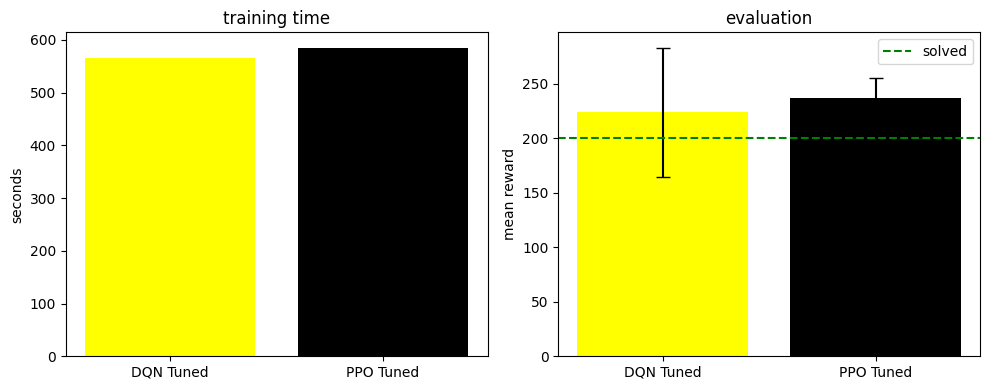

In [14]:
# tunning parameters using the Stable-Baselines3 RL Zoo repository

# DQN tunning
env = gym.make("LunarLander-v3")
dqn_tuned_start = time.time()
dqn_tuned = DQN("MlpPolicy", env, learning_rate=6.3e-4, buffer_size=50000,
                batch_size=128, gamma=0.99, exploration_fraction=0.12,
                exploration_final_eps=0.1, target_update_interval=250, verbose=0)
dqn_tuned.learn(total_timesteps=TIMESTEPS)
dqn_tuned_time = time.time() - dqn_tuned_start
env.close()

# PPO tunning
env = gym.make("LunarLander-v3")
ppo_tuned_start = time.time()
ppo_tuned = PPO("MlpPolicy", env, learning_rate=1e-3, n_steps=1024, batch_size=64,
                n_epochs=4, gamma=0.999, gae_lambda=0.98, ent_coef=0.01, verbose=0)
ppo_tuned.learn(total_timesteps=TIMESTEPS)
ppo_tuned_time = time.time() - ppo_tuned_start
env.close()

# models evaluation
dqn_tuned_rewards = evaluate(dqn_tuned)
ppo_tuned_rewards = evaluate(ppo_tuned)

print(f"DQN Tuned (time): {dqn_tuned_time:.1f}s, Mean Reward: {np.mean(dqn_tuned_rewards):.2f}")
print(f"PPO Tuned (time): {ppo_tuned_time:.1f}s, Mean Reward: {np.mean(ppo_tuned_rewards):.2f}")

# part of task 7: generating visualizations (charts)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(['DQN Tuned', 'PPO Tuned'], [dqn_tuned_time, ppo_tuned_time], color=['yellow', 'black'])
axes[0].set_ylabel('seconds')
axes[0].set_title('training time')

axes[1].bar(['DQN Tuned', 'PPO Tuned'], [np.mean(dqn_tuned_rewards), np.mean(ppo_tuned_rewards)],
            yerr=[np.std(dqn_tuned_rewards), np.std(ppo_tuned_rewards)], color=['yellow', 'black'], capsize=5)
axes[1].axhline(200, color='green', linestyle='--', label='solved')
axes[1].set_ylabel('mean reward')
axes[1].set_title('evaluation')
axes[1].legend()
plt.tight_layout()
plt.show()

# 8b: Using DeepMind and OpenAI papers (using their proposed hyperparameters)

DQN (time): 575.5s, Mean Reward: 150.39
PPO (time): 790.6s, Mean Reward: 239.78


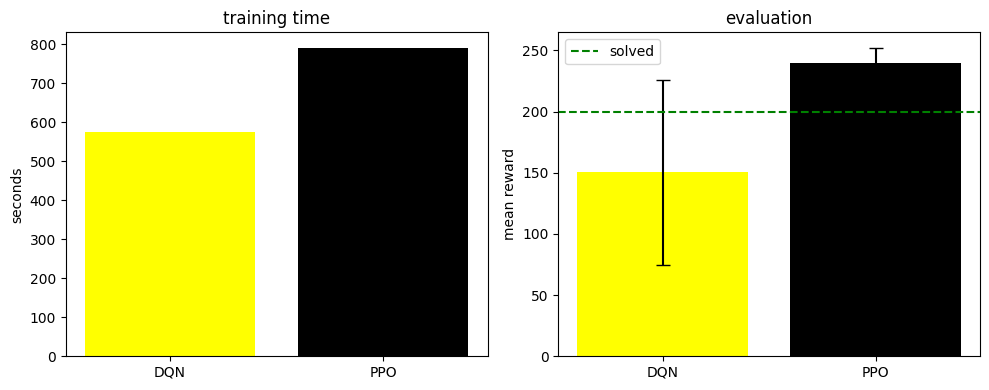

In [16]:
# tuning parameters using the following papers:
# - for DQN: Mnih et al., 2015 "Human-level control through deep reinforcement learning"
# - for PPO: Schulman et al., 2017 "Proximal Policy Optimization Algorithms"

# DQN
env = gym.make("LunarLander-v3")
dqn_paper_start = time.time()
dqn_paper = DQN("MlpPolicy", env, learning_rate=2.5e-4, buffer_size=100000,
                batch_size=32, gamma=0.99, exploration_fraction=0.1,
                exploration_final_eps=0.01, target_update_interval=1000, verbose=0)
dqn_paper.learn(total_timesteps=TIMESTEPS)
dqn_paper_time = time.time() - dqn_paper_start
env.close()

# PPO
env = gym.make("LunarLander-v3")
ppo_paper_start = time.time()
ppo_paper = PPO("MlpPolicy", env, learning_rate=3e-4, n_steps=2048, batch_size=64,
                n_epochs=10, gamma=0.99, gae_lambda=0.95, ent_coef=0.0, verbose=0)
ppo_paper.learn(total_timesteps=TIMESTEPS)
ppo_paper_time = time.time() - ppo_paper_start
env.close()

# evaluation
dqn_paper_rewards = evaluate(dqn_paper)
ppo_paper_rewards = evaluate(ppo_paper)

print(f"DQN (time): {dqn_paper_time:.1f}s, Mean Reward: {np.mean(dqn_paper_rewards):.2f}")
print(f"PPO (time): {ppo_paper_time:.1f}s, Mean Reward: {np.mean(ppo_paper_rewards):.2f}")

# visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(['DQN', 'PPO'], [dqn_paper_time, ppo_paper_time], color=['yellow', 'black'])
axes[0].set_ylabel('seconds')
axes[0].set_title('training time')

axes[1].bar(['DQN', 'PPO'], [np.mean(dqn_paper_rewards), np.mean(ppo_paper_rewards)],
            yerr=[np.std(dqn_paper_rewards), np.std(ppo_paper_rewards)], color=['yellow', 'black'], capsize=5)
axes[1].axhline(200, color='green', linestyle='--', label='solved')
axes[1].set_ylabel('mean reward')
axes[1].set_title('evaluation')
axes[1].legend()
plt.tight_layout()
plt.show()

# Summary

1. **Ο PPO ειναι πιο σταθερος απο τον DQN**. Ο PPO ελυσε το περιβαλλον (>200) και στις τρεις ρυθμισεις, ανεξαρτητα απο το hyperparameter tuning. Ο DQN το ελυσε μονο μια φορα με το SB3 RL Zoo tuning. Αυτο επιβεβαιωνει οτι ο PPO ειναι γενικα πιο σταθερος και λιγοτερο ευαισθητος στην επιλογη των hyperparameters.

<br>

2.   **Το hyperparameter tuning βελτιωνει σημαντικα τον DQN**. Ο DQN ανεβηκε απο 97 (προεπιλογη) σε 223 (SB3 RL Zoo tunning), βελτιωση +126 ποντων. Αυτο δειχνει οτι ο DQN εξαρταται σε μεγαλο βαθμο απο τη σωστη ρυθμιση hyperparameters για να αποδωσει καλα.

<br>

3. **Το tuning για συγκεκριμενο περιβαλλον ξεπερνα τις γενικες ρυθμισεις των papers**. Οι παραμετροι του  SB3 RL Zoo (ρυθμισμενες ειδικα για το LunarLander) εδωσαν το καλυτερο αποτελεσμα DQN (223 εναντι 150 απο τα papers). Οι αρχικες παραμετροι του DQN paper σχεδιαστηκαν για παιχνιδια Atari με εικονες, οχι για απλα διανυσματα 8 διαστασεων οπως το LunarLander.

<br>

4. **Ο PPO αποδιδει σταθερα σε ολες τις ρυθμισεις**. Ο PPO πετυχε μεταξυ 237-254 και στις τρεις εκτελεσεις, με διακυμανση μικροτερη απο 7%. Ο DQN κυμανθηκε απο 97-223, με διακυμανση πανω απο 100%. Για εφαρμογες πραγματικου κοσμου οπου η αξιοπιστια μετραει, ο PPO ειναι η ασφαλεστερη επιλογη.

<br>

5. **Ο προεπιλεγμενος PPO ξεπερασε τον ρυθμισμενο DQN σε καποιες περιπτωσεις**. Ολως περιεργως, ο PPO με προεπιλεγμενες παραμετρους (254) πετυχε υψηλοτερο σκορ απο τον DQN με SB3 RL Zoo tuning (223). Αυτο δειχνει οτι η επιλογη αλγοριθμου μπορει να ειναι πιο σημαντικη απο το hyperparameter tuning.